## TEST

In [1]:
# import packages
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.layers import Dense, Convolution1D, Convolution2D, MaxPool1D, Flatten, Dropout, AveragePooling1D
from keras.layers import Input
from keras.models import Model, Sequential
#from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.utils import resample
import tensorflow as tf
import logging
import warnings
import os


logging.getLogger("tensorflow").setLevel(logging.DEBUG)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
warnings.filterwarnings('ignore')

In [4]:
# Load data
train_df=pd.read_csv('src/mitbih_train.csv',header=None)
test_df=pd.read_csv('src/mitbih_test.csv',header=None)

# Scale the values to 16bit uint (0-65535)
rows, cols = train_df.shape
train_df_int = pd.DataFrame(index=range(rows+1), columns=range(cols+1))
train_df_int = train_df.mul(65535)
train_df_int[187] = train_df[187]

rows, cols = test_df.shape
test_df_int = pd.DataFrame(index=range(rows+1), columns=range(cols+1))
test_df_int = test_df.mul(65535)
test_df_int[187] = test_df[187]

# Float to int 
train_df_int = train_df_int.astype(int)
test_df_int = test_df_int.astype(int)

#train_df = train_df_int
#test_df = test_df_int

train_df = train_df.astype(np.float32)
test_df = test_df.astype(np.float32)

#print(train_df_int.head())
print(train_df.tail())

train_df_int.to_csv('src/mitbih_test_int.csv', header=None)

            0         1         2         3         4         5         6    \
87549  0.807018  0.494737  0.536842  0.529825  0.491228  0.484211  0.456140   
87550  0.718333  0.605000  0.486667  0.361667  0.231667  0.120000  0.051667   
87551  0.906122  0.624490  0.595918  0.575510  0.530612  0.481633  0.444898   
87552  0.858228  0.645570  0.845570  0.248101  0.167089  0.131646  0.121519   
87553  0.901506  0.845886  0.800695  0.748552  0.687138  0.599073  0.512167   

            7         8         9    ...  178  179  180  181  182  183  184  \
87549  0.396491  0.284211  0.136842  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
87550  0.001667  0.000000  0.013333  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
87551  0.387755  0.322449  0.191837  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
87552  0.121519  0.118987  0.103797  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
87553  0.427578  0.395133  0.402086  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       185  186  187  
87549  0.0  0.0  4.0  
8755

In [24]:
# Training parameters
EPOCHS = 20 #40 seems ok
BATCH_SIZE = 32

Resampling data to balance the classes

```
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])
```

In [25]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values

# Calculate derivative on data
X_test_der = np.empty_like(X_test)
X_train_der = np.empty_like(X_train)
for i in range(len(X_test)):
    X_test_der[i] = np.gradient(X_test[i])
    X_train_der[i] = np.gradient(X_train[i])

# Use derivative for CNN
X_train = X_train.reshape(len(X_train_der), X_train_der.shape[1],1)
X_test = X_test.reshape(len(X_test_der), X_test_der.shape[1],1)

# Use normal data for CNN
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
print(target_train)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
87549    4.0
87550    4.0
87551    4.0
87552    4.0
87553    4.0
Name: 187, Length: 87554, dtype: float32


In [26]:
im_shape=(X_train.shape[1],1)
model = Sequential([
    Input(shape=(im_shape), name='inputs_cnn'),
    #AveragePooling1D(2),
    Convolution1D(1, (3), strides=1, padding="same", activation='relu'),
    MaxPool1D(2),
    #Dropout(0.1),
    Convolution1D(1, (5), strides=3, activation='relu'),
    MaxPool1D(2),
    Flatten(name='flat_1'),
    Dense(30, activation='relu'),
    Dense(5, activation='softmax', name='main_output')
])

#model = Model(inputs= inputs_cnn, outputs=main_output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
model.summary()
#model.count_params()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 186, 1)         │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 93, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 30, 1)          │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat_1 (Flatten)                │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │           155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 645 (2.52 KB)

 Trainable params: 645 (2.52 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
keras.config.disable_traceback_filtering()

model_num = 0
while os.path.exists("models/model_%s.keras" % f"{model_num:02}"):
    model_num += 1
log_dir = "logs/fit/model_" + str(f"{model_num:02}")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history=model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test,y_test), callbacks=[tensorboard_callback])

model_name = 'model_'+ str(f"{model_num:02}")
model_path = 'models/' + model_name + '.keras'
model.name = model_name
model.save(model_path)


Epoch 1/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8355 - loss: 0.7254 - val_accuracy: 0.8889 - val_loss: 0.4243
Epoch 2/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8923 - loss: 0.4032 - val_accuracy: 0.8987 - val_loss: 0.3754
Epoch 3/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9003 - loss: 0.3591 - val_accuracy: 0.9042 - val_loss: 0.3488
Epoch 4/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9070 - loss: 0.3302 - val_accuracy: 0.9052 - val_loss: 0.3362
Epoch 5/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9095 - loss: 0.3190 - val_accuracy: 0.9053 - val_loss: 0.3256
Epoch 6/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9113 - loss: 0.3075 - val_accuracy: 0.9103 - val_loss: 0.3139
Epoch 7/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9112 - loss: 0.3034 - val_accuracy: 0.9106 - val_loss: 0.3068
Epoch 8/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9117 - loss: 0.2988 

In [28]:
model.export("test", "tf_saved_model")
converter = tf.lite.TFLiteConverter.from_saved_model('test')

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: test\assets


INFO:tensorflow:Assets written to: test\assets


Saved artifact at 'test'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 186, 1), dtype=tf.float32, name='inputs_cnn')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2491961460336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491961460512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491961461568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491961461744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491961462800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491961462976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491961463504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491961463328: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [29]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
    yield [input_value]

model.export("test", "tf_saved_model")
converter = tf.lite.TFLiteConverter.from_saved_model('test')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: test\assets


INFO:tensorflow:Assets written to: test\assets


Saved artifact at 'test'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 186, 1), dtype=tf.float32, name='inputs_cnn')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2491961460336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491961460512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491961461568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491961461744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491961462800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491961462976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491961463504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491961463328: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [30]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [31]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

7552

In [32]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, X_test_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(X_test_indices),), dtype=int)
  for i, test_image_index in enumerate(X_test_indices):
    test_image = X_test[test_image_index]
    test_label = y_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()
    

  return predictions

In [33]:
y_prediction = model.predict(X_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(y_test, axis=1)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
classes = [0,1,2,3,4]
result_norm = np.around(result, 4)
mat_result = pd.DataFrame(result_norm,
                     index = classes, 
                     columns = classes)
print(y_prediction)
print(mat_result)

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[0 0 0 ... 0 4 4]
        0       1       2       3       4
0  0.9218  0.1625  0.1055  0.0000  0.0073
1  0.0253  0.7250  0.0054  0.0000  0.0000
2  0.0335  0.1000  0.8303  0.3333  0.0154
3  0.0078  0.0000  0.0065  0.6667  0.0000
4  0.0116  0.0125  0.0522  0.0000  0.9773


In [34]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  X_test_indices = range(X_test.shape[0])
  predictions = run_tflite_model(tflite_file, X_test_indices)
  print(predictions)
  #y_prediction = np.argmax (predictions)
  y_prediction = predictions
  #y_test=np.argmax(y_test)

  #Create confusion matrix and normalizes it over predicted (columns)
  result = confusion_matrix(y_test, y_prediction , normalize='pred')
  classes = [0,1,2,3,4]
  result_norm = np.around(result, 4)
  mat_result = pd.DataFrame(result_norm,
                      index = classes, 
                      columns = classes)
  print(mat_result)
  figure = plt.figure(figsize=(4, 4))
  sns.heatmap(mat_result, annot=True,cmap=plt.cm.Blues)
  plt.title(model_name)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.savefig(log_dir + '/' + model_name + '.png', pad_inches=0.1)
  plt.show()

  #accuracy = (np.sum(y_test== predictions) * 100) / len(X_test)

  #print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
  #    model_type, accuracy, len(X_test)))

[0 0 0 ... 0 4 4]
        0       1       2       3       4
0  0.9218  0.1625  0.1055  0.0000  0.0073
1  0.0253  0.7250  0.0054  0.0000  0.0000
2  0.0335  0.1000  0.8303  0.3333  0.0154
3  0.0078  0.0000  0.0065  0.6667  0.0000
4  0.0116  0.0125  0.0522  0.0000  0.9773


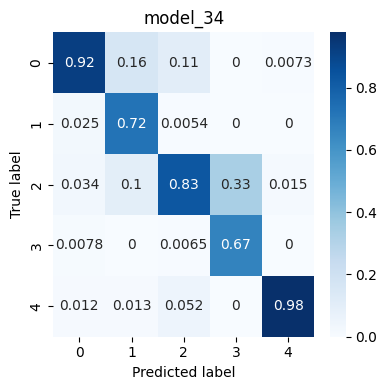

[0 0 0 ... 0 4 4]
        0       1       2    3       4
0  0.9198  0.1667  0.0940  0.0  0.0059
1  0.0260  0.6833  0.0057  0.0  0.0000
2  0.0346  0.1500  0.8414  0.2  0.0133
3  0.0078  0.0000  0.0068  0.8  0.0000
4  0.0119  0.0000  0.0521  0.0  0.9808


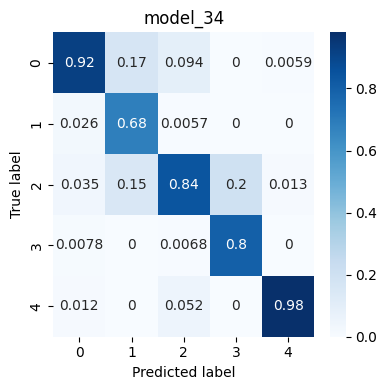

In [35]:
evaluate_model(tflite_model_file, model_type="Float")
evaluate_model(tflite_model_quant_file, model_type="Quantized")

In [36]:
total_pred = np.trace(result) / 5
print(total_pred)

0.8242025556910093


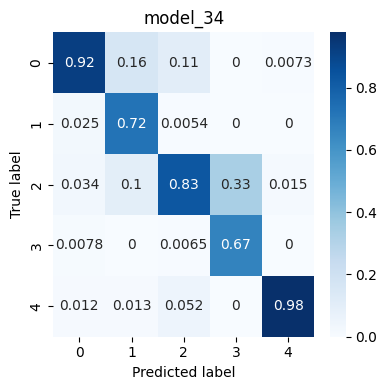

In [37]:
figure = plt.figure(figsize=(4, 4))
sns.heatmap(mat_result, annot=True,cmap=plt.cm.Blues)
plt.title(model_name)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(log_dir + '/' + model_name + '.png', pad_inches=0.1)
plt.show()

In [38]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.
